<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from geometry import find_max_dist_brute, find_max_dist

In [19]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [20]:
class G1(DatasetGenerator):
  def refresh(self, seed=1):
    if seed is not None:
      np.random.seed(seed)
    self.v = np.random.uniform(low=0, high=1, size=self.N)
    self.x = np.random.uniform(low=0, high=1, size=(self.N,2))

In [21]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

In [22]:
g1 = G1()
g2 = G2()

NameError: name 'N' is not defined

In [23]:
class MCMCSolver: 
    def __init__(self, dataset,lmbd,beta = 0.1):
        self.dataset = dataset
        self.state = np.random.binomial(1, 0, dataset.N).astype(bool) #randomly initialize state
        self.lmbd = lmbd
        self.beta = beta
               
    #code from solvers 
    def dist(self,pt1: np.ndarray, pt2: np.ndarray) -> np.float:
        return np.linalg.norm(pt1 - pt2, ord=2)
    
    def objective(self):
        #to use the functions from geometry.py
        mask = self.dataset.x[self.state]
        return (self.state*self.dataset.v).sum() - self.lmbd*self.dataset.N*np.pi*(find_max_dist(mask)/2)**2
#         return (self.state*self.dataset.v).sum() - self.lmbd*self.dataset.N*np.pi*(self.radius(self.state)/2)**2
        
    #compute the radius of the state
    #direct computation, probably more clever way to compute radius difference
    def radius(self,state):
        best = 0
        for k,i in enumerate(state):
            if i > 0:
                for l,j in enumerate(state):
                    if j > 0:
                        best = np.maximum(best,self.dist(self.dataset.x[k],self.dataset.x[l]))
        return best
    
    def compute_diff(self,state_1,state_2,i):
        diff_1 = (int(state_2[i]) - int(state_1[i]))*self.dataset.v[i]
#         diff_2 = self.lmbd*self.dataset.N*np.pi*((self.radius(state_2)/2)**2-(self.radius(state_1)/2)**2)

        #to use the functions from geometry.py
        mask_1 = self.dataset.x[state_1]
        mask_2 = self.dataset.x[state_2]
        diff_2 = self.lmbd*self.dataset.N*np.pi*((find_max_dist(mask_2)/2)**2-(find_max_dist(mask_1)/2)**2)
        return diff_1-diff_2

    def acceptance_proba(self,diff,beta):
        proba = np.exp(beta*diff)
        return np.minimum(1.0,proba)
    
    def solve(self,n_it):
        np.random.seed(99)
        print("Initial state:",self.state)
        n_states = []
        objectives = []
        for it in range(n_it):
            #print("Iteration",it)
            next_state = self.state.copy()
            
            #flip one state at random
            i = np.random.choice(self.dataset.N)
            next_state[i] = True^next_state[i]
                        
            #update state with acceptance probability
            diff = self.compute_diff(self.state, next_state,i)
            if np.random.uniform() < self.acceptance_proba(diff, self.beta):
                self.state = next_state
            #print(self.state.sum())
            #print()
            
            #record number of states and objective for plotting, as per project description
            if (it % 1) == 0:
                n_states.append(self.state.sum())
                objectives.append(self.objective())
                
            #beta scheduling    
            if ((it % 500) == 0) and (it > 0):
                self.beta = self.beta*5  
        
        print("Final state:",self.state)
        return n_states,objectives

In [24]:
print(g1.v)
mcmc = MCMCSolver(dataset = g1, lmbd = 1, beta = 1)
n_states, objectives = mcmc.solve(n_it = 2000)

[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01
 2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01
 4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01
 8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
 8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
 1.69830420e-01 8.78142503e-01 9.83468338e-02 4.21107625e-01
 9.57889530e-01 5.33165285e-01 6.91877114e-01 3.15515631e-01
 6.86500928e-01 8.34625672e-01 1.82882773e-02 7.50144315e-01
 9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01
 1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01
 2.87775339e-01 1.30028572e-01 1.93669579e-02 6.78835533e-01
 2.11628116e-01 2.65546659e-01 4.91573159e-01 5.33625451e-02
 5.74117605e-01 1.46728575e-01 5.89305537e-01 6.99758360e-01
 1.02334429e-01 4.14055988e-01 6.94400158e-01 4.14179270e-01
 4.99534589e-02 5.358964

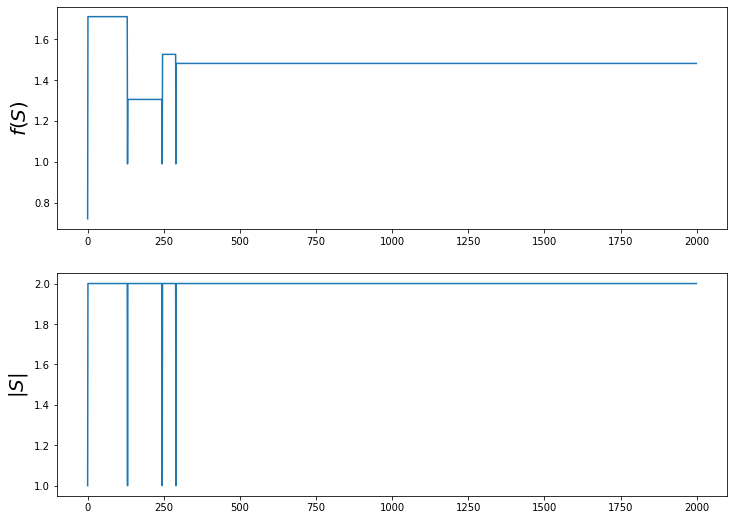

In [25]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,9))
axs[0].plot(objectives)
axs[0].set_ylabel(f'$f(S)$', fontsize=20)
axs[1].plot(n_states)
axs[1].set_ylabel(f'$|S|$', fontsize=20)
plt.show()